The Custom VGG16 and UNET model. doesnt support training

In [2]:
# Data Processing and Visualization
import os                  # Operating system-specific functionalities
import random              # Generates pseudo-random numbers
import glob                # Finds all the pathnames matching a specified pattern
import re                  # Regular expression operations

# Data Manipulation and Analysis
import numpy as np         # Fundamental package for scientific computing with Python
import pandas as pd        # Data manipulation and analysis library

# Image Processing and Visualization
import matplotlib.pyplot as plt   # Data visualization library
import cv2                        # OpenCV for image processing
from skimage import io            # Image I/O library from scikit-image

# Deep Learning Framework (TensorFlow/Keras)
import tensorflow as tf                     # Open-source machine learning library
from tensorflow.keras.layers import (       # Keras layers for building neural networks
    Conv2D, BatchNormalization, Activation, Conv2DTranspose, Concatenate, Input
)
from tensorflow.keras.models import Model   # Model class for defining neural network models

# Specific TensorFlow/Keras Components
from tensorflow.keras import layers, optimizers  # Different components for building and training neural networks
from tensorflow.keras.initializers import glorot_uniform  # Glorot (Xavier) weight initializer
from tensorflow.keras.utils import plot_model  # Utility for plotting model architectures
from tensorflow.keras.callbacks import (  # Callbacks for adjusting learning rate during training
    ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
)
import tensorflow.keras.backend as K  # Keras backend for low-level operations

# Other Libraries
from sklearn.preprocessing import StandardScaler, normalize  # For data preprocessing
from IPython.display import display  # Display utilities for IPython environments
from keras.models import load_model  # Loading models in Keras
from keras.losses import binary_crossentropy  # Binary cross-entropy loss function


In [3]:
data_map = []

# Specify the path to your dataset on your Windows machine
dataset_path = "datasets/unzip/lgg-mri-segmentation/kaggle_3m"

# Iterate over subdirectories in the specified path
for sub_dir_path in glob.glob(dataset_path + "/*"):
    # Check if the current path is a directory
    if os.path.isdir(sub_dir_path):
        try:
            dir_name = sub_dir_path.split('/')[-1]

            # Iterate over files in the directory
            for filename in os.listdir(sub_dir_path):
                image_path = os.path.join(sub_dir_path, filename)
                data_map.append((dir_name, image_path))
        except Exception as e:
            print(e)

# Display the data_map
print(data_map)


[('kaggle_3m\\TCGA_CS_4941_19960909', 'datasets/unzip/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_1.tif'), ('kaggle_3m\\TCGA_CS_4941_19960909', 'datasets/unzip/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_10.tif'), ('kaggle_3m\\TCGA_CS_4941_19960909', 'datasets/unzip/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_10_mask.tif'), ('kaggle_3m\\TCGA_CS_4941_19960909', 'datasets/unzip/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_11.tif'), ('kaggle_3m\\TCGA_CS_4941_19960909', 'datasets/unzip/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_11_mask.tif'), ('kaggle_3m\\TCGA_CS_4941_19960909', 'datasets/unzip/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_12.tif'), ('kaggle_3m\\TCGA_CS_4941_19960909', 'datasets/unzip/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_12_mask.tif'), ('kag

In [5]:
# Create a DataFrame from the data_map list
df = pd.DataFrame({"patient_id": [item[0] for item in data_map],
                   "path": [item[1] for item in data_map]})

# Display the first few rows of the DataFrame
df.head()


patient_id  \
0  kaggle_3m\TCGA_CS_4941_19960909   
1  kaggle_3m\TCGA_CS_4941_19960909   
2  kaggle_3m\TCGA_CS_4941_19960909   
3  kaggle_3m\TCGA_CS_4941_19960909   
4  kaggle_3m\TCGA_CS_4941_19960909   

                                                path  
0  datasets/unzip/lgg-mri-segmentation/kaggle_3m\...  
1  datasets/unzip/lgg-mri-segmentation/kaggle_3m\...  
2  datasets/unzip/lgg-mri-segmentation/kaggle_3m\...  
3  datasets/unzip/lgg-mri-segmentation/kaggle_3m\...  
4  datasets/unzip/lgg-mri-segmentation/kaggle_3m\...

In [6]:
# Filtering image paths
df_imgs = df[~df['path'].str.contains("mask")]  # Exclude paths containing "mask"
df_masks = df[df['path'].str.contains("mask")]  # Include only paths containing "mask"

# Creating a dictionary for mask paths
mask_dict = {path[:-9]: path for path in df_masks["path"].values}  # Removing 'mask.tif' to get the corresponding image path

# Pairing each image with its corresponding mask
pairs = []
for img_path in df_imgs["path"].values:
    mask_path = mask_dict.get(img_path[:-4])  # Remove the '.tif' from the image path
    if mask_path:
        pairs.append((img_path, mask_path))

# Randomly selecting one pair of image and mask
idx = random.randint(0, len(pairs)-1)
img_path, mask_path = pairs[idx]
print("Path to the Image:", img_path, "\nPath to the Mask:", mask_path)


Path to the Image: datasets/unzip/lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_7.tif 
Path to the Mask: datasets/unzip/lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_7_mask.tif


In [8]:
# Final dataframe
brain_df = pd.DataFrame(pairs, columns=["image_path", "mask_path"])

# Extract patient_id from image_path
brain_df["patient_id"] = brain_df["image_path"].apply(lambda x: x.split("/")[-2])

# Define a function to determine positive/negative diagnosis
def pos_neg_diagnosis(mask_path):
    return int(np.max(cv2.imread(mask_path)) > 0)

# Apply the function to create the 'mask' column
brain_df['mask'] = brain_df['mask_path'].apply(pos_neg_diagnosis)

# Display the final DataFrame
brain_df


image_path  \
0     datasets/unzip/lgg-mri-segmentation/kaggle_3m\...   
1     datasets/unzip/lgg-mri-segmentation/kaggle_3m\...   
2     datasets/unzip/lgg-mri-segmentation/kaggle_3m\...   
3     datasets/unzip/lgg-mri-segmentation/kaggle_3m\...   
4     datasets/unzip/lgg-mri-segmentation/kaggle_3m\...   
...                                                 ...   
3924  datasets/unzip/lgg-mri-segmentation/kaggle_3m\...   
3925  datasets/unzip/lgg-mri-segmentation/kaggle_3m\...   
3926  datasets/unzip/lgg-mri-segmentation/kaggle_3m\...   
3927  datasets/unzip/lgg-mri-segmentation/kaggle_3m\...   
3928  datasets/unzip/lgg-mri-segmentation/kaggle_3m\...   

                                              mask_path            patient_id  \
0     datasets/unzip/lgg-mri-segmentation/kaggle_3m\...  lgg-mri-segmentation   
1     datasets/unzip/lgg-mri-segmentation/kaggle_3m\...  lgg-mri-segmentation   
2     datasets/unzip/lgg-mri-segmentation/kaggle_3m\...  lgg-mri-segmentation   
3     datasets/unzip/lgg-mri-segmentation/kaggle_3m\...  lgg-mri-segmentation   
4     datasets/unzip/lgg-mri-segmentation/kaggle_3m\...  lgg-mri-segmentation   
...                                                 ...                   ...   
3924  datasets/unzip/lgg-mri-segmentation/kaggle_3m\...  lgg-mri-segmentation   
3925  datasets/unzip/lgg-mri-segmentation/kaggle_3m\...  lgg-mri-segmentation   
3926  datasets/unzip/lgg-mri-segmentation/kaggle_3m\...  lgg-mri-segmentation   
3927  datasets/unzip/lgg-mri-segmentation/kaggle_3m\...  lgg-mri-segmentation   
3928  datasets/unzip/lgg-mri-segmentation/kaggle_3m\...  lgg-mri-segmentation   

      mask  
0        0  
1        0  
2        1  
3        1  
4        1  
...    ...  
3924     0  
3925     0  
3926     0  
3927     0  
3928     0  

[3929 rows x 4 columns]

In [39]:
# Calculate and display the value counts of the 'mask' column
mask_value_counts = brain_df['mask'].value_counts()

# Display the result
print("Value Counts of 'mask' column:")
print(mask_value_counts)


Value Counts of 'mask' column:
mask
0    1806
1     991
Name: count, dtype: int64


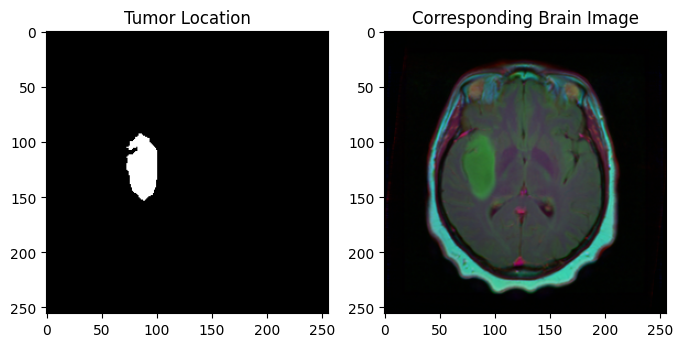

In [40]:
# Loop through the DataFrame to find the first image with a non-zero maximum pixel value in the mask
for i in range(len(brain_df)):
    if cv2.imread(brain_df.mask_path[i]).max() > 0:
        break

# Display the tumor location and corresponding brain image
plt.figure(figsize=(8, 8))

# Tumor Location
plt.subplot(1, 2, 1)
plt.imshow(cv2.imread(brain_df.mask_path[i]))
plt.title('Tumor Location')

# Corresponding Brain Image
plt.subplot(1, 2, 2)
plt.imshow(cv2.imread(brain_df.image_path[i]))
plt.title('Corresponding Brain Image')

# Show the plots
plt.show()


In [41]:
# Calculate the maximum and minimum pixel values in the mask image
max_pixel_value = cv2.imread(brain_df.mask_path[i]).max()
min_pixel_value = cv2.imread(brain_df.mask_path[i]).min()

# Display the calculated values
print("Max Pixel Value in the Mask Image:", max_pixel_value)
print("Min Pixel Value in the Mask Image:", min_pixel_value)


Max Pixel Value in the Mask Image: 255
Min Pixel Value in the Mask Image: 0


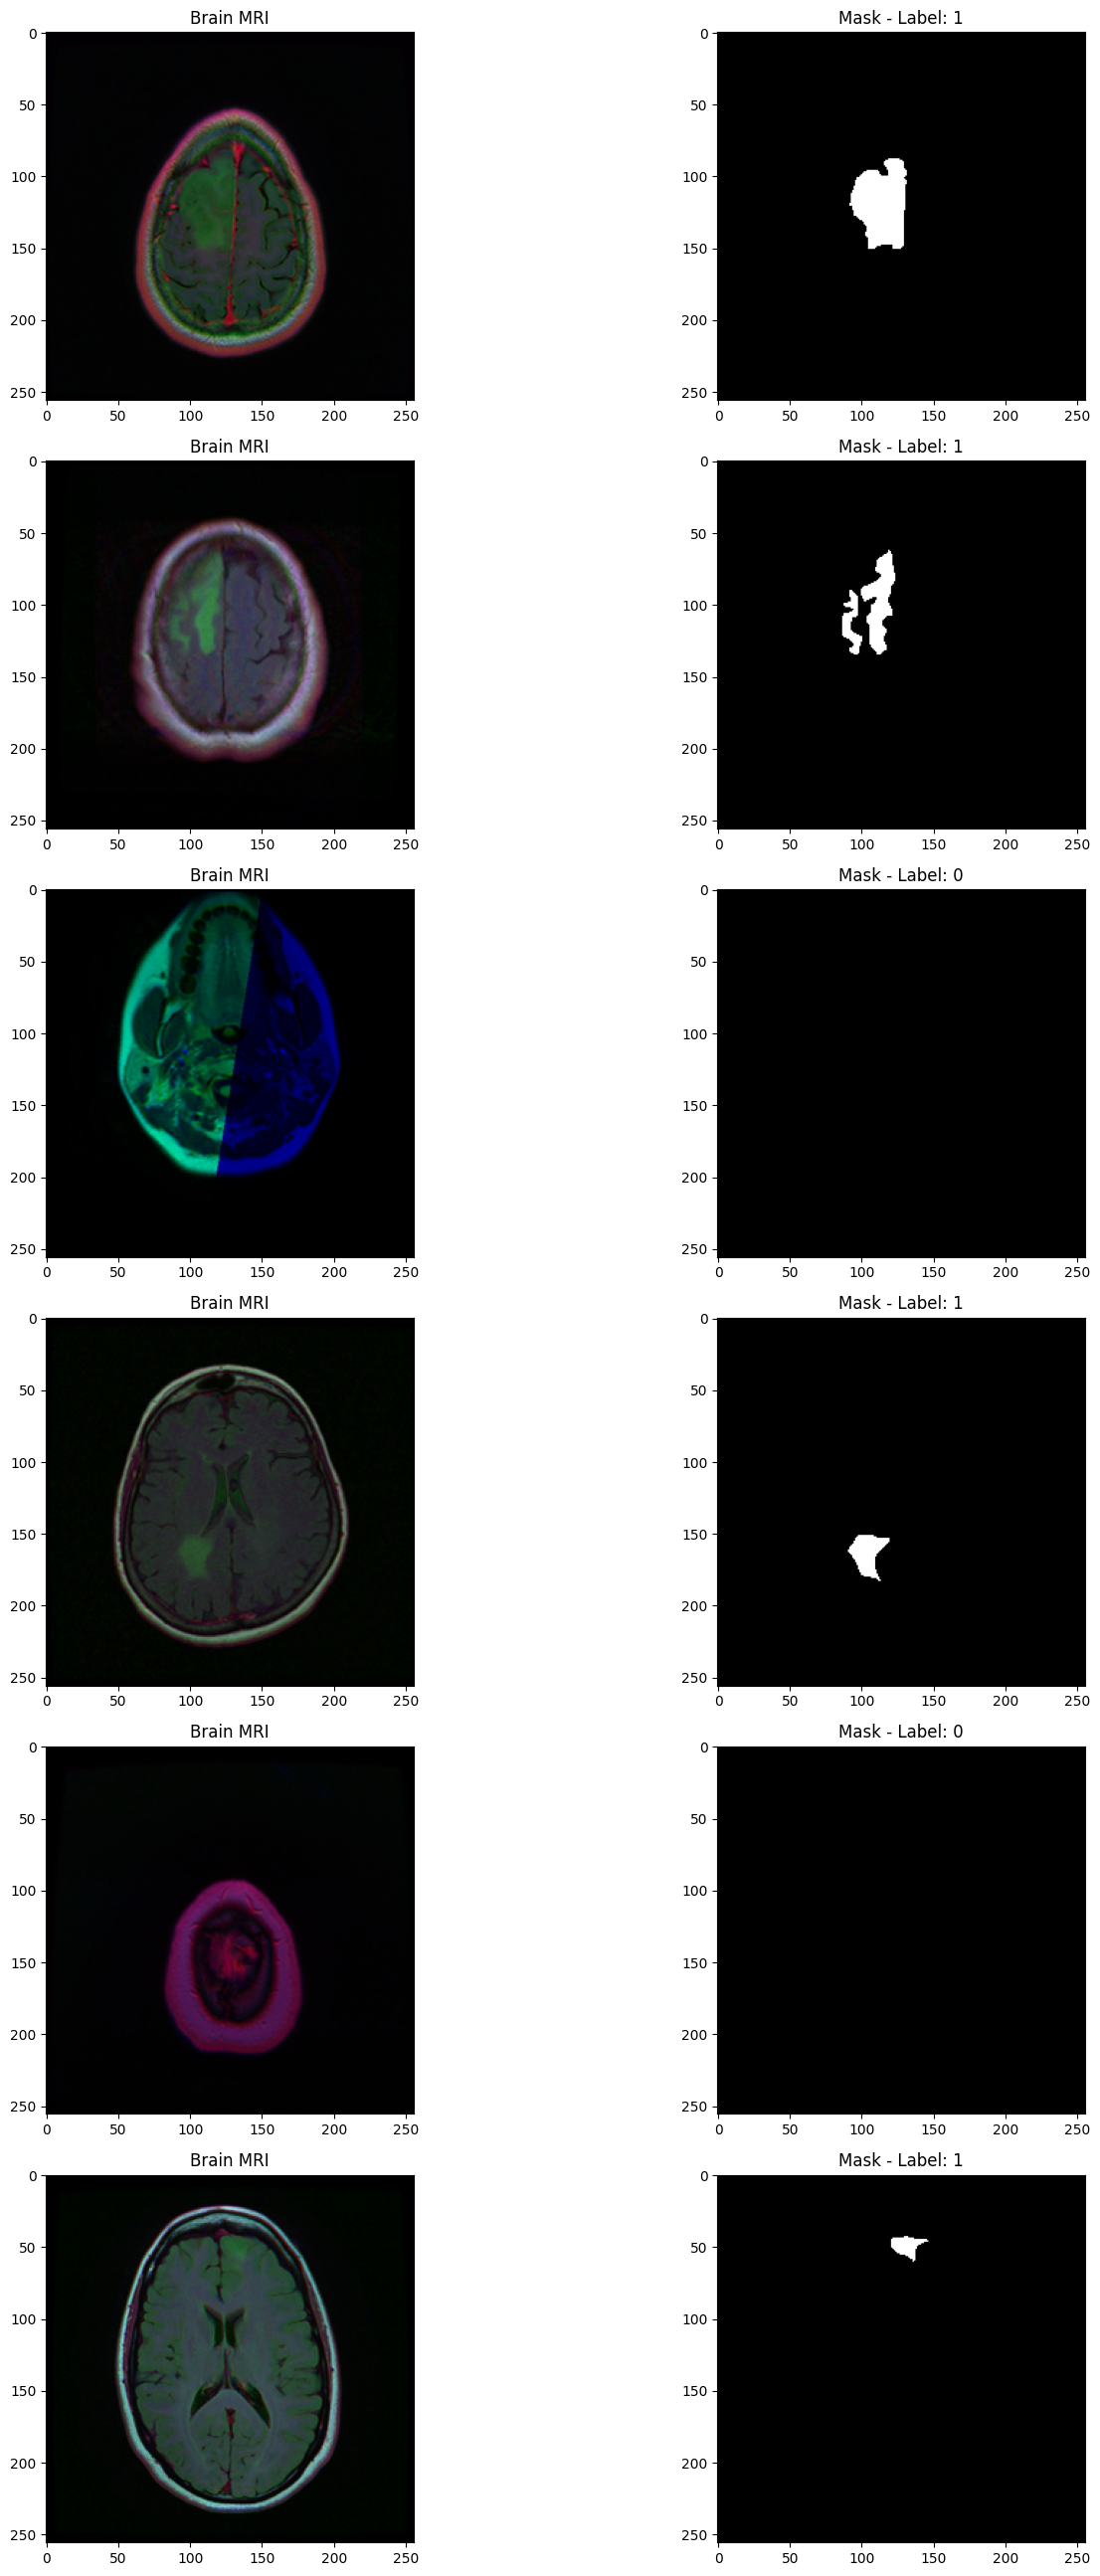

In [42]:
# Basic visualizations: Visualize the images (MRI and Mask) in the dataset separately

# Create a 6x2 grid for subplots
fig, axs = plt.subplots(6, 2, figsize=(16, 26))
count = 0

# Loop through rows in the grid
for x in range(6):
    # Select a random index
    i = random.randint(0, len(brain_df))

    # Display Brain MRI
    axs[count][0].set_title("Brain MRI")  # set title
    axs[count][0].imshow(cv2.imread(brain_df.image_path[i]))  # show MRI

    # Display Mask with label
    axs[count][1].set_title(f"Mask - Label: {brain_df['mask'][i]}")  # plot title on the mask (0 or 1)
    axs[count][1].imshow(cv2.imread(brain_df.mask_path[i]))  # Show corresponding mask

    count += 1

# Adjust layout for better visualization
fig.tight_layout()

# Display the plots
plt.show()


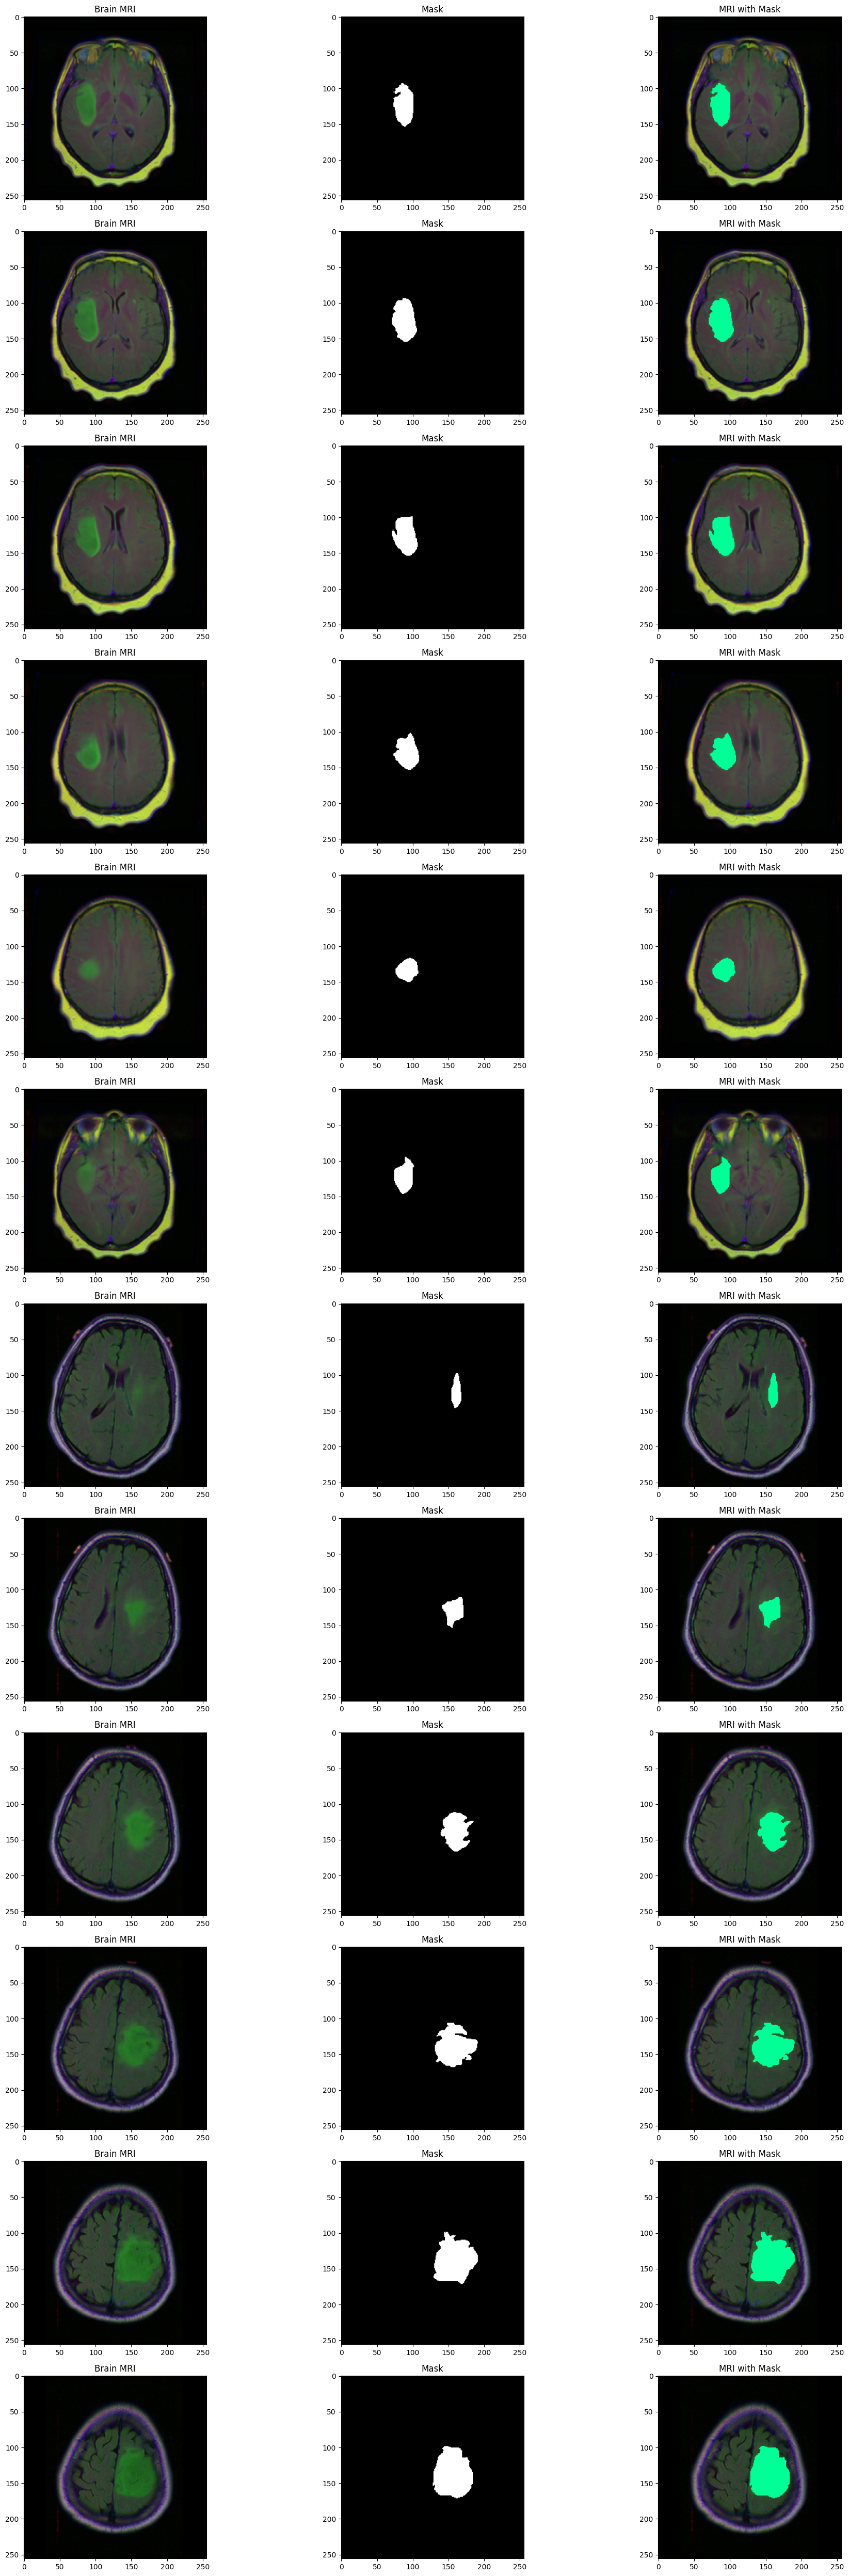

In [47]:
count = 0
i = 0
fig,axs = plt.subplots(12,3, figsize=(20,50))
for mask in brain_df['mask']:
    if (mask==1):
        img = io.imread(brain_df.image_path[i])
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)

        mask = io.imread(brain_df.mask_path[i])
        axs[count][1].title.set_text("Mask")
        axs[count][1].imshow(mask, cmap='gray')

        img[mask==255] = (0,255,150)  # change pixel color at the position of mask
        axs[count][2].title.set_text("MRI with Mask")
        axs[count][2].imshow(img)
        count +=1
    i += 1
    if (count==12):
        break

fig.tight_layout()

In [49]:
# Drop the 'patient_id' column
brain_df_train = brain_df.drop(columns=['patient_id'])

# Convert the data in the 'mask' column to string format
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

# Display information about the DataFrame
brain_df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2797 entries, 0 to 2796
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  2797 non-null   object
 1   mask_path   2797 non-null   object
 2   mask        2797 non-null   object
dtypes: object(3)
memory usage: 65.7+ KB


In [51]:
# Create a new DataFrame 'brain_df_mask' with rows where 'mask' is equal to 1
brain_df_mask = brain_df[brain_df['mask'] == 1]

# Display the shape of the filtered DataFrame
print("Shape of brain_df_mask:", brain_df_mask.shape)


Shape of brain_df_mask: (991, 4)


In [53]:
from sklearn.model_selection import train_test_split

# Split the 'brain_df_train' DataFrame into training and testing sets 
train, test = train_test_split(brain_df_train, test_size=0.15) #85% for Training 15% for Testing


In [57]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)

# Split the validation set into validation and test
X_val, X_test = train_test_split(X_val, test_size=0.5)

# Print the sizes of the sets
print("Train size is {}, valid size is {} & test size is {}".format(len(X_train), len(X_val), len(X_test)))

# Extract image and mask paths for the training set
train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

# Extract image and mask paths for the validation set
val_ids = list(X_val.image_path)
val_mask = list(X_val.mask_path)


Train size is 842, valid size is 74 & test size is 75


In [60]:
from sklearn.utils import shuffle

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, mask_paths, labels, image_dir='./', batch_size=16, img_h=256, img_w=256, shuffle=True):
        # Input parameters
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.labels = labels
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.img_h = img_h
        self.img_w = img_w
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Get the number of batches per epoch'
        return int(np.floor(len(self.image_paths)) / self.batch_size)

    def __getitem__(self, index):
        'Generate a batch of data'
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        list_image_paths = [self.image_paths[i] for i in indexes]
        list_mask_paths = [self.mask_paths[i] for i in indexes]
        list_labels = [self.labels[i] for i in indexes]

        X, y = self.__data_generation(list_image_paths, list_mask_paths, list_labels)
        return X, y

    def on_epoch_end(self):
        'Used for updating the indices after each epoch, once at the beginning as well as at the end of each epoch'
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_image_paths, list_mask_paths, list_labels):
        'Generate the data corresponding to the indexes in a given batch of images'
        X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
        y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

        for i in range(len(list_image_paths)):
            image_path = str(list_image_paths[i])
            mask_path = str(list_mask_paths[i])
            label = list_labels[i]

            image = io.imread(image_path)
            mask = io.imread(mask_path)

            if image is None or mask is None:
                print(f"Warning: Image or mask is empty at path: {image_path}, {mask_path}")
                continue

            try:
                # Resize images
                image = cv2.resize(image, (self.img_h, self.img_w))
                mask = cv2.resize(mask, (self.img_h, self.img_w))

                # Convert to float32
                image = np.array(image, dtype=np.float32)
                mask = np.array(mask, dtype=np.float32)

                # Normalization for input images
                image -= image.mean()
                image /= image.std()

            except cv2.error as e:
                print(f"Error resizing image: {e}")
                print(f"Image path: {image_path}")
                continue

            X[i,] = image
            y[i,] = np.expand_dims(mask, axis=2)

        y = (y > 0).astype(int)
        return X, {'output_mask': y, 'output_label': np.array(list_labels)}

# Example usage:
labels_train = [0] * len(train_ids)  
labels_val = [0] * len(val_ids)  

train_data = DataGenerator(image_paths=train_ids, mask_paths=train_mask, labels=labels_train)
val_data = DataGenerator(image_paths=val_ids, mask_paths=val_mask, labels=labels_val)


In [83]:
# Import necessary libraries
from tensorflow.keras import layers, models

# Define VGG16 Encoder
def vgg16_encoder(input_tensor):
    # Block 1
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(input_tensor)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    s1 = x  # Save the feature map for decoder
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    s2 = x  # Save the feature map for decoder
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    s3 = x  # Save the feature map for decoder

    return s3, s2, s1

# Define U-Net Decoder
def unet_decoder(conv4, conv3, conv2, conv1):
    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv4)
    u6 = layers.concatenate([u6, conv3], axis=-1)
    u6 = layers.BatchNormalization()(u6)
    u6 = layers.Activation('elu')(u6)
    u6 = layers.Conv2D(512, (3, 3), activation='elu', padding='same')(u6)
    u6 = layers.Conv2D(512, (3, 3), activation='elu', padding='same')(u6)
    u6 = layers.Dropout(0.5)(u6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(u6)
    u7 = layers.concatenate([u7, conv2], axis=-1)
    u7 = layers.BatchNormalization()(u7)
    u7 = layers.Activation('elu')(u7)
    u7 = layers.Conv2D(256, (3, 3), activation='elu', padding='same')(u7)
    u7 = layers.Conv2D(256, (3, 3), activation='elu', padding='same')(u7)
    u7 = layers.Dropout(0.5)(u7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(u7)

    # Adjust the shape of conv1 to match the shape of u8
    conv1_adjusted = layers.Conv2D(128, (1, 1), activation='elu')(conv1)
    conv1_adjusted = layers.UpSampling2D(size=(2, 2))(conv1_adjusted)

    u8 = layers.concatenate([u8, conv1_adjusted], axis=-1)
    u8 = layers.BatchNormalization()(u8)
    u8 = layers.Activation('elu')(u8)
    u8 = layers.Conv2D(128, (3, 3), activation='elu', padding='same')(u8)
    u8 = layers.Conv2D(128, (3, 3), activation='elu', padding='same')(u8)
    u8 = layers.Dropout(0.5)(u8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u8)
    u9 = layers.BatchNormalization()(u9)
    u9 = layers.Activation('elu')(u9)
    u9 = layers.Conv2D(64, (3, 3), activation='elu', padding='same')(u9)
    u9 = layers.Conv2D(64, (3, 3), activation='elu', padding='same')(u9)
    u9 = layers.Dropout(0.5)(u9)

    return u9

# Build VGG16 U-Net Model
def build_vgg16_unet(input_shape):
    """ Input """
    inputs = layers.Input(input_shape)

    """ Encoder """
    s3, s2, s1 = vgg16_encoder(inputs)

    """ Decoder (U-Net) """
    u_net_decoder_output = unet_decoder(s3, s2, s1, s1)

    """ Output """
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(u_net_decoder_output)

    model = models.Model(inputs, outputs, name="Optimized_VGG16_U-Net")
    return model

# Example usage
seg_model = build_vgg16_unet((256, 256, 3))
seg_model.summary()


Model: "Optimized_VGG16_U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_20 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 256, 256, 64)         1792      ['input_20[0][0]']            
                                                                                                  
 block1_conv2 (Conv2D)       (None, 256, 256, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)         0         ['block1_conv2[0][0]']        
                                                                              

In [84]:
from keras.losses import binary_crossentropy

# Small constant values to avoid division by zero
epsilon = 1e-5
smooth = 1

# Tversky index for semantic segmentation
def tversky(y_true, y_pred, alpha=0.7):
    # Flatten the true and predicted tensors
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)

    # Calculate true positive, false negative, and false positive
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)

    # Tversky index formula
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)

# Focal Tversky loss for semantic segmentation
def focal_tversky(y_true, y_pred, gamma=0.75):
    # Cast true and predicted tensors to float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Calculate the Tversky index
    pt_1 = tversky(y_true, y_pred)

    # Focal Tversky formula
    return K.pow((1 - pt_1), gamma)

# Tversky loss for semantic segmentation
def tversky_loss(y_true, y_pred):
    # Calculate the complement of the Tversky index
    return 1 - tversky(y_true, y_pred)


In [87]:
adam = tf.keras.optimizers.Adam(learning_rate=0.05, epsilon=0.1)
seg_model.compile(optimizer=adam,
                  loss=focal_tversky,
                  metrics=[tversky]
                 )

# callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=20
                             )

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="datasets/weights/UNet_VGG16-segModel-weights.hdf5",
                               verbose=1,
                               save_best_only=True,
                               restore_best_weights=True  # Add this line to restore best weights
                              )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )


In [92]:
# Fit the model
h = seg_model.fit(train_data,
                  epochs=200,  # Update with your desired number of epochs
                  validation_data=(val_data, val_labels),  # Update with your validation data and labels
                  callbacks=[checkpointer, earlystopping, reduce_lr],
                  verbose=1)

NameError: name 'val_labels' is not defined

In [ ]:
test_ids = list(X_test.image_path)
test_mask = list(X_test.mask_path)
test_data = DataGenerator(test_ids, test_mask)
_, tv = seg_model.evaluate(test_data)
print("Segmentation tversky is {:.2f}%".format(tv*100))